---
# Part 1: 环境准备与初始化
---

## 1. 环境准备

In [30]:
import sys
sys.path.append('..')

import numpy as np
import cv2
from pathlib import Path
import matplotlib.pyplot as plt

# 配置 matplotlib 中文显示
plt.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei', 'SimSun', 'KaiTi', 'Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示为方块的问题

# 导入自定义模块
from src.custom_ocr import CustomTextRecognizer, PostProcessingPipeline
from src.custom_ocr.processors import TopKDecoder, CTCDeduplicator, ConfidenceFilter

print("✓ 模块导入成功")
print("✓ Matplotlib 中文支持已配置")

✓ 模块导入成功
✓ Matplotlib 中文支持已配置


## 2. 初始化识别器

In [2]:
# 初始化自定义识别器
recognizer = CustomTextRecognizer(
    model_name='PP-OCRv5_server_rec',
    device='gpu:0'  # 如果没有 GPU，改为 'cpu'
)

print("\n模型信息:")
model_info = recognizer.get_model_info()
for key, value in model_info.items():
    print(f"  {key}: {value}")

Model files already exist. Using cached files. To redownload, please delete the directory manually: `C:\Users\Quenton\.paddlex\official_models\PP-OCRv5_server_rec`.
c:\Users\Quenton\Documents\Github\writtingOCR\venv\lib\site-packages\paddle\utils\cpp_extension\extension_utils.py:718: UserWarning: No ccache found. Please be aware that recompiling all source files may be required. You can download and install ccache from: https://github.com/ccache/ccache/blob/master/doc/INSTALL.md
  warnings.warn(warning_message)
c:\Users\Quenton\Documents\Github\writtingOCR\venv\lib\site-packages\paddle\utils\cpp_extension\extension_utils.py:718: UserWarning: No ccache found. Please be aware that recompiling all source files may be required. You can download and install ccache from: https://github.com/ccache/ccache/blob/master/doc/INSTALL.md
  warnings.warn(warning_message)


找不到指定的程序。 Error loading "c:\Users\Quenton\Documents\Github\writtingOCR\venv\lib\site-packages\paddle\..\nvidia\cudnn\bin\cudnn_cnn64_9.dll" or one of its dependencies.
找不到指定的程序。 Error loading "c:\Users\Quenton\Documents\Github\writtingOCR\venv\lib\site-packages\paddle\..\nvidia\cudnn\bin\cudnn_engines_precompiled64_9.dll" or one of its dependencies.
找不到指定的程序。 Error loading "c:\Users\Quenton\Documents\Github\writtingOCR\venv\lib\site-packages\paddle\..\nvidia\cudnn\bin\cudnn_engines_runtime_compiled64_9.dll" or one of its dependencies.
找不到指定的程序。 Error loading "c:\Users\Quenton\Documents\Github\writtingOCR\venv\lib\site-packages\paddle\..\nvidia\cudnn\bin\cudnn_heuristic64_9.dll" or one of its dependencies.
✓ 加载模型: PP-OCRv5_server_rec
✓ 字符类别数: 18385
✓ 设备: gpu:0

模型信息:
  model_name: PP-OCRv5_server_rec
  num_characters: 18385
  blank_index: 0
  preprocessors: ['Read', 'ReisizeNorm', 'ToBatch']
✓ 加载模型: PP-OCRv5_server_rec
✓ 字符类别数: 18385
✓ 设备: gpu:0

模型信息:
  model_name: PP-OCRv5_server_rec


## 3. 加载测试数据

本 notebook 完全独立运行，不依赖其他 notebook 的变量。

In [3]:
from pathlib import Path
import re

# 项目根目录
project_root = Path('..').resolve()

# 1. 加载图像
img_path = project_root / 'output' / 'temp_cropped.png'
img = cv2.imread(str(img_path))

if img is None:
    raise FileNotFoundError(f"无法加载图像: {img_path}\n请确保文件存在")

print(f"✓ 加载图像: {img.shape}")

# 2. 加载 Ground Truth（读取为字符串）
gt_file = project_root / 'data' / 'samples' / '2022 第2題 (冬奧) (8份)_Original' / 'sample_01_01_ground_truth.txt'
with open(gt_file, 'r', encoding='utf-8') as f:
    ground_truth = f.read()

print(f"✓ 加载 Ground Truth: {len(ground_truth)} 字符")

# 3. 清理 ground truth（移除 <insert></insert> 和 <?> 标记，移除换行和空格）
gt_clean = re.sub(r'<insert>|</insert>|<\?>', '', ground_truth)
gt_clean = gt_clean.replace('\n', '').replace(' ', '')

print(f"✓ 清理后的 Ground Truth: {len(gt_clean)} 字符")
print(f"前 100 字符: {gt_clean[:100]}")

✓ 加载图像: (2900, 2170, 3)
✓ 加载 Ground Truth: 711 字符
✓ 清理后的 Ground Truth: 552 字符
前 100 字符: 親愛的你：你好！我是一名普通的香港人。首先，請容許我爲自己的俗氣致歉。畢竟我倆素未謀面，再加上我是一名老實人，實在寫不出些精妙絕倫又討好非常的句子，唯有難爲你頂著這俗氣難當的石頭繼續閲讀下去。你或許會


## 3.1 格子检测与分割

从 src.preprocessing 导入格子检测方法

In [4]:
# 从 src.preprocessing 导入格子检测方法
from src.preprocessing.grid_detection import detect_grid_lines, generate_grid_cells

# 转换为灰度图（detect_grid_lines 需要灰度图）
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# 检测格子线
print("检测格子线...")
lines = detect_grid_lines(gray)
horizontal_lines = lines['horizontal']
vertical_lines = lines['vertical']
print(f"✓ 检测到横线: {len(horizontal_lines)} 条")
print(f"✓ 检测到竖线: {len(vertical_lines)} 条")

# 生成格子
print("\n生成格子网格...")
cells = generate_grid_cells(horizontal_lines, vertical_lines, img.shape[:2])
print(f"✓ 生成格子: {len(cells)} 个")

# 过滤非空格子并裁剪图像（改进版：裁剪中心区域 + 提升阈值）
print("\n过滤非空格子并裁剪...")
cell_images = []
non_empty_cells = []

for cell in cells:
    x1, y1, x2, y2 = cell['x1'], cell['y1'], cell['x2'], cell['y2']
    cell_img = img[y1:y2, x1:x2]
    
    # 判断是否为非空格子
    if cell_img.size > 0:
        gray_cell = cv2.cvtColor(cell_img, cv2.COLOR_BGR2GRAY)
        
        # 裁剪中心区域（避免边框干扰）
        h, w = gray_cell.shape
        crop = int(min(h, w) * 0.08)  # 裁剪 8%
        if h > 2*crop and w > 2*crop:  # 确保裁剪后还有内容
            center_region = gray_cell[crop:h-crop, crop:w-crop]
        else:
            center_region = gray_cell  # 格子太小，不裁剪
        
        # 计算中心区域的非白色像素比例
        non_white_ratio = (center_region < 240).sum() / center_region.size
        if non_white_ratio > 0.005:  # 超过0.5%的非白色像素认为是非空
            cell_images.append(cell_img)
            non_empty_cells.append(cell)

print(f"✓ 非空格子数: {len(cell_images)}")
print(f"✓ Ground Truth 字符数: {len(gt_clean)}")

检测格子线...
✓ 检测到横线: 259 条
✓ 检测到竖线: 190 条

生成格子网格...
✓ 生成格子: 580 个

过滤非空格子并裁剪...
✓ 非空格子数: 532
✓ Ground Truth 字符数: 552
✓ 检测到横线: 259 条
✓ 检测到竖线: 190 条

生成格子网格...
✓ 生成格子: 580 个

过滤非空格子并裁剪...
✓ 非空格子数: 532
✓ Ground Truth 字符数: 552


## 3.2 可视化部分格子（可选）

可视化格子网格布局...
网格大小: 29 行 × 20 列
总格子数: 580
非空格子数: 532
空格子数: 48


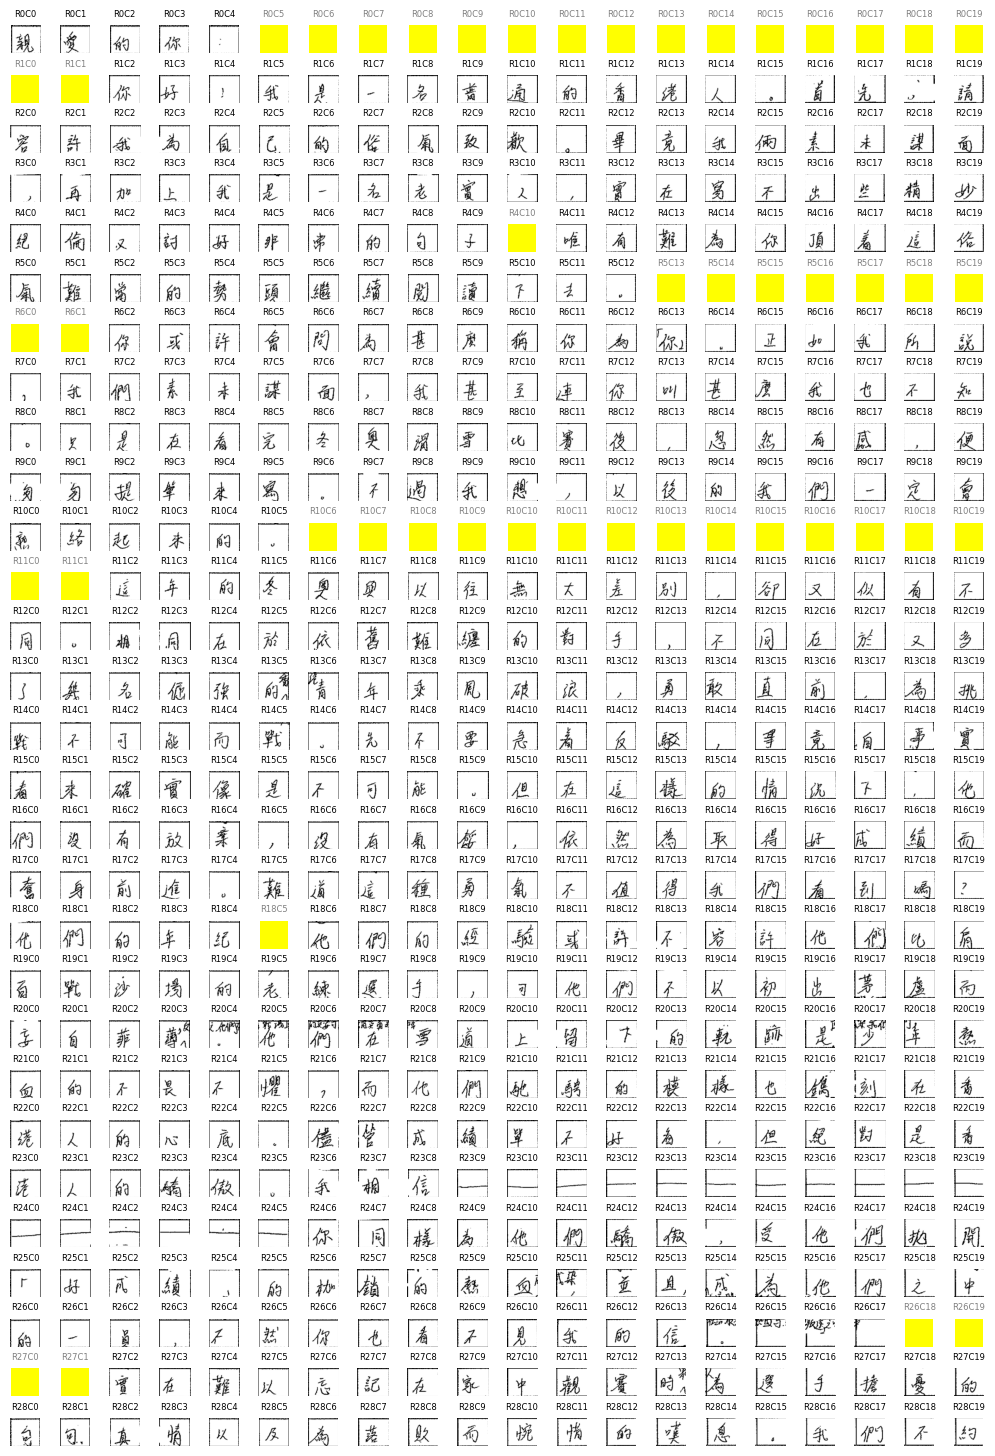


✓ 网格可视化完成
  - 白色格子：非空格子（有内容）
  - 黄色格子：空格子或被过滤的格子


In [5]:
# 可视化格子网格（显示完整布局，空格子用黄色占位）
print("可视化格子网格布局...")

# 获取网格的行列数
rows = max([cell['row'] for cell in cells]) + 1
cols = max([cell['col'] for cell in cells]) + 1

print(f"网格大小: {rows} 行 × {cols} 列")
print(f"总格子数: {len(cells)}")
print(f"非空格子数: {len(cell_images)}")
print(f"空格子数: {len(cells) - len(cell_images)}")

# 创建一个字典，方便根据 (row, col) 查找格子
non_empty_dict = {(cell['row'], cell['col']): idx for idx, cell in enumerate(non_empty_cells)}

# 计算子图布局（限制显示范围，避免过大）
max_display_rows = min(rows, 30)
max_display_cols = min(cols, 30)

if max_display_rows < rows or max_display_cols < cols:
    print(f"⚠️  网格过大，仅显示前 {max_display_rows} 行 × {max_display_cols} 列")

# 创建画布
fig_width = max(10, max_display_cols * 0.5)
fig_height = max(8, max_display_rows * 0.5)
fig, axes = plt.subplots(max_display_rows, max_display_cols, 
                         figsize=(fig_width, fig_height))

# 如果只有一行或一列，确保 axes 是二维数组
if max_display_rows == 1:
    axes = axes.reshape(1, -1)
elif max_display_cols == 1:
    axes = axes.reshape(-1, 1)

# 遍历网格
for row in range(max_display_rows):
    for col in range(max_display_cols):
        ax = axes[row, col]
        ax.axis('off')
        
        # 检查该位置是否有非空格子
        if (row, col) in non_empty_dict:
            # 显示非空格子
            idx = non_empty_dict[(row, col)]
            cell_img = cell_images[idx]
            ax.imshow(cv2.cvtColor(cell_img, cv2.COLOR_BGR2RGB))
            ax.set_title(f'R{row}C{col}', fontsize=6)
        else:
            # 显示黄色占位符（表示空格子或被过滤的格子）
            yellow_img = np.ones((50, 50, 3)) * np.array([1.0, 1.0, 0.0])  # RGB 黄色
            ax.imshow(yellow_img)
            ax.set_title(f'R{row}C{col}', fontsize=6, color='gray')

plt.tight_layout(pad=0.5)
plt.show()

print(f"\n✓ 网格可视化完成")
print(f"  - 白色格子：非空格子（有内容）")
print(f"  - 黄色格子：空格子或被过滤的格子")

## 4. 辅助函数定义

定义在整个 notebook 中复用的辅助函数

In [23]:
def restore_empty_cells(results_list, cells, non_empty_cells):
    """
    恢复空格子，构建完整的预测结果
    
    参数:
        results_list: OCR识别结果列表（非空格子）
        cells: 所有格子列表（包括空格子）
        non_empty_cells: 非空格子列表
        
    返回:
        prediction_data_full: 完整预测结果（包含空格子）
    """
    # 1. 创建完整的格子字典（包括空格子）
    all_cells_dict = {}
    for cell in cells:
        row, col = cell['row'], cell['col']
        all_cells_dict[(row, col)] = {
            'row': row,
            'col': col,
            'text': '',           # 默认为空
            'confidence': 1.0,    # 空格子置信度设为 1.0
            'is_empty': True      # 标记为空格子
        }
    
    # 2. 填充非空格子的识别结果
    for i, (result, cell) in enumerate(zip(results_list, non_empty_cells)):
        row, col = cell['row'], cell['col']
        all_cells_dict[(row, col)] = {
            'row': row,
            'col': col,
            'text': result.get('text', ''),
            'confidence': result.get('confidence', 0),
            'is_empty': False,
            'ocr_result': result  # 保存完整的 OCR 结果（包含 top_k 等）
        }
    
    # 3. 转换为列表（按 row, col 排序）
    prediction_data_full = sorted(all_cells_dict.values(), 
                                  key=lambda x: (x['row'], x['col']))
    
    return prediction_data_full


def reconstruct_cell_data(metrics_dict):
    """
    从 by_row 结构重构完整的格子列表
    
    参数:
        metrics_dict: GridAccuracyCalculator 返回的结果字典
        
    返回:
        pred_cells: 带元数据的预测格子列表
        gt_cells: Ground Truth 文本列表
    """
    pred_cells = []
    gt_cells = []
    
    for row_result in metrics_dict['by_row']:
        row_idx = row_result['row']
        for col_idx, (pred_text, gt_text, conf) in enumerate(
            zip(row_result['pred_cells'], row_result['gt_cells'], 
                row_result['confidences'])
        ):
            pred_cells.append({
                'row': row_idx,
                'col': col_idx,
                'text': pred_text,
                'confidence': conf,
                'is_empty': (pred_text == '')
            })
            gt_cells.append({
                'row': row_idx,
                'col': col_idx,
                'text': gt_text
            })
    
    return pred_cells, gt_cells


def display_row_comparison(row_idx, pred_cells, gt_cells, enhanced_cells=None):
    """
    显示单行的对比（原始预测 vs Ground Truth vs 增强预测）
    
    参数:
        row_idx: 行索引
        pred_cells: 原始预测的格子列表
        gt_cells: Ground Truth 的格子列表
        enhanced_cells: 增强预测的格子列表（可选）
    """
    print(f"\n{'='*80}")
    print(f"第 {row_idx} 行对比")
    print(f"{'='*80}")
    
    # 获取该行的格子
    pred_row = [c for c in pred_cells if c['row'] == row_idx]
    gt_row = [c for c in gt_cells if c['row'] == row_idx]
    
    # 对齐到相同长度
    max_len = max(len(pred_row), len(gt_row))
    
    # 打印表头
    print(f"{'Col':<5} {'预测':<10} {'GT':<10}", end='')
    if enhanced_cells:
        enhanced_row = [c for c in enhanced_cells if c['row'] == row_idx]
        print(f" {'增强':<10} {'改变':<6}", end='')
    print(f" {'匹配':<6}")
    print(f"{'-'*80}")
    
    # 打印每列
    for col in range(max_len):
        pred_text = pred_row[col]['text'] if col < len(pred_row) else ''
        gt_text = gt_row[col]['text'] if col < len(gt_row) else ''
        
        # 判断是否匹配
        is_match = (pred_text == gt_text)
        match_str = '✓' if is_match else '✗'
        
        print(f"{col:<5} {pred_text:<10} {gt_text:<10}", end='')
        
        if enhanced_cells and col < len(enhanced_row):
            enhanced_text = enhanced_row[col]['text']
            is_changed = (enhanced_text != pred_text)
            changed_str = '→' if is_changed else ''
            enhanced_match = (enhanced_text == gt_text)
            enhanced_match_str = '✓' if enhanced_match else '✗'
            print(f" {enhanced_text:<10} {changed_str:<6}", end='')
            print(f" {match_str} → {enhanced_match_str}")
        else:
            print(f" {match_str}")
    

print(f"{'-'*80}")


print("✓ 辅助函数定义完成")

--------------------------------------------------------------------------------
✓ 辅助函数定义完成


## 5. 全局处理器初始化

创建共享的处理器实例，在整个 notebook 中复用（避免重复加载 BERT 模型）

In [11]:
# 导入处理器
from src.custom_ocr.processors.grid_context_enhancer import GridContextEnhancer

# 初始化共享的处理器实例
print("初始化全局处理器...")

# 1. Top-K 解码器
decoder = TopKDecoder(k=5)
print("✓ Top-K 解码器 (k=5)")

# 2. CTC 去重器
deduplicator = CTCDeduplicator()
print("✓ CTC 去重器")

# 3. 置信度过滤器
conf_filter = ConfidenceFilter(threshold=0.3)
print("✓ 置信度过滤器 (threshold=0.3)")

# 4. 格子级 BERT 增强器
grid_enhancer = GridContextEnhancer(
    model_name='bert-base-chinese',
    device='cuda:0',  # 如果没有 GPU，改为 'cpu'
    context_window=10,    # 上下文窗口：前后各5个格子
    confidence_threshold=0.8  # 低于此置信度的格子才会被BERT增强
)
print("✓ 格子级 BERT 增强器")
print(f"  - 模型: {grid_enhancer.model_name}")
print(f"  - 设备: {grid_enhancer.device}")
print(f"  - 窗口大小: {grid_enhancer.context_window}")
print(f"  - 置信度阈值: {grid_enhancer.confidence_threshold}")

print("\n所有处理器初始化完成！")

初始化全局处理器...
✓ Top-K 解码器 (k=5)
✓ CTC 去重器
✓ 置信度过滤器 (threshold=0.3)
✓ GridContextEnhancer 初始化完成
  模型: bert-base-chinese
  上下文窗口: ±10 个格子
  融合权重: 60.0% OCR + 40.0% BERT
  设备: cuda:0
✓ 格子级 BERT 增强器
  - 模型: bert-base-chinese
  - 设备: cuda:0
  - 窗口大小: 10
  - 置信度阈值: 0.8

所有处理器初始化完成！


---
# Part 2: 原始 OCR Pipeline（方法链式调用）
---

## 6. 批量处理所有格子（方法链式调用）

使用**方法链式调用**（而非 Pipeline），每一步的输出都可见

In [12]:
# 批量处理所有格子
print("批量处理所有格子...")
print("="*80)

# 步骤 1: 获取原始概率矩阵（批量）
print("\n步骤 1: 获取原始概率矩阵...")
batch_raw_outputs = recognizer.batch_predict_with_raw_output(cell_images)
print(f"✓ 获取 {len(batch_raw_outputs)} 个格子的概率矩阵")

# 步骤 2: 方法链式调用（每步可见）
print("\n步骤 2: 执行后处理...")
results_list = []

for i, raw_output in enumerate(batch_raw_outputs):
    # 2.1 Top-K 解码
    decoded = decoder(raw_output)
    
    # 2.2 CTC 去重
    deduped = deduplicator(decoded)
    
    # 2.3 置信度过滤
    filtered = conf_filter(deduped)
    
    results_list.append(filtered)
    
    # 打印前10个格子的结果
    if i < 10:
        text = filtered.get('text', '')
        confidence = filtered.get('confidence', 0)
        print(f"  格子 {i+1:3d}: '{text:8s}' (置信度: {confidence:.3f})")

print(f"\n✓ 处理完成！共处理 {len(results_list)} 个非空格子")

# 步骤 3: 恢复空格子
print("\n步骤 3: 恢复空格子...")
prediction_data_full = restore_empty_cells(results_list, cells, non_empty_cells)

print(f"✓ 完整预测结果: {len(prediction_data_full)} 个格子")
print(f"  - 非空格子: {len([c for c in prediction_data_full if not c['is_empty']])} 个")
print(f"  - 空格子: {len([c for c in prediction_data_full if c['is_empty']])} 个")

# 验证：显示第一行的格子分布
first_row_cells = [c for c in prediction_data_full if c['row'] == 0]
print(f"\n第一行格子分布（共 {len(first_row_cells)} 个）:")
for cell in first_row_cells[:10]:  # 只显示前10个
    status = "空" if cell['is_empty'] else f"'{cell['text']}'"
    print(f"  col {cell['col']}: {status}")

批量处理所有格子...

步骤 1: 获取原始概率矩阵...
✓ 获取 532 个格子的概率矩阵

步骤 2: 执行后处理...
  格子   1: '親       ' (置信度: 0.975)
  格子   2: '爱       ' (置信度: 0.865)
  格子   3: '的       ' (置信度: 0.999)
  格子   4: '你       ' (置信度: 0.996)
  格子   5: '.co     ' (置信度: 0.539)
  格子   6: '你       ' (置信度: 0.998)
  格子   7: '好       ' (置信度: 0.996)
  格子   8: '1       ' (置信度: 0.503)
  格子   9: '我       ' (置信度: 1.000)
  格子  10: '是       ' (置信度: 0.999)
✓ 获取 532 个格子的概率矩阵

步骤 2: 执行后处理...
  格子   1: '親       ' (置信度: 0.975)
  格子   2: '爱       ' (置信度: 0.865)
  格子   3: '的       ' (置信度: 0.999)
  格子   4: '你       ' (置信度: 0.996)
  格子   5: '.co     ' (置信度: 0.539)
  格子   6: '你       ' (置信度: 0.998)
  格子   7: '好       ' (置信度: 0.996)
  格子   8: '1       ' (置信度: 0.503)
  格子   9: '我       ' (置信度: 1.000)
  格子  10: '是       ' (置信度: 0.999)

✓ 处理完成！共处理 532 个非空格子

步骤 3: 恢复空格子...
✓ 完整预测结果: 580 个格子
  - 非空格子: 532 个
  - 空格子: 48 个

第一行格子分布（共 20 个）:
  col 0: '親'
  col 1: '爱'
  col 2: '的'
  col 3: '你'
  col 4: '.co'
  col 5: 空
  col 6: 空
  col 7: 空
  col 8: 空
  col 

## 7. 原始 OCR 准确率评估

In [13]:
# 导入自定义评估模块
from src.evaluation import GridAccuracyCalculator

# 创建计算器实例
calculator = GridAccuracyCalculator(empty_char='')

# 计算准确率
print("计算原始 OCR 准确率...")
print("="*80)

metrics = calculator.calculate(
    predicted_results=prediction_data_full,
    ground_truth=ground_truth,
    align_by_row=True
)

# 打印结果
print("\n原始 OCR 准确率:")
print(f"  字符准确率: {metrics['overall']['accuracy']:.2f}%")
print(f"  正确字符数: {metrics['overall']['matched_chars']}")
print(f"  总字符数: {metrics['overall']['total_chars']}")
print(f"  格子匹配数: {sum(r['cell_matches'] for r in metrics['by_row'])}")
print(f"  总格子数: {sum(r['total_cells'] for r in metrics['by_row'])}")

if 'by_row' in metrics:
    print(f"\n按行统计:")
    for row_info in metrics['by_row'][:5]:  # 显示前5行
        print(f"  第 {row_info['row']} 行: {row_info['cell_matches']}/{row_info['total_cells']} "
              f"({row_info['accuracy']:.2f}%)")

pred_cells, gt_cells = reconstruct_cell_data(metrics)
# 重构完整的格子数据（供后续分析使用）

计算原始 OCR 准确率...

原始 OCR 准确率:
  字符准确率: 75.00%
  正确字符数: 387
  总字符数: 516
  格子匹配数: 425
  总格子数: 583

按行统计:
  第 0 行: 18/20 (90.00%)
  第 1 行: 17/20 (85.00%)
  第 2 行: 15/20 (75.00%)
  第 3 行: 15/20 (75.00%)
  第 4 行: 15/20 (75.00%)


## 8. 识别错误分析

In [14]:
# 分析识别错误
print("识别错误分析")
print("="*80)

if 'by_row' not in metrics:
    print("⚠️  缺少详细对比数据，无法分析错误")
else:
    # 使用已重构的格子数据（在 Section 7 中生成）
    
    # 统计错误类型
    error_count = 0
    low_conf_errors = []
    high_conf_errors = []
    
    for pred, gt in zip(pred_cells, gt_cells):
        if pred['text'] != gt['text']:
            error_count += 1
            conf = pred.get('confidence', 0)
            if conf < 0.6:
                low_conf_errors.append((pred, gt['text'], conf))
            else:
                high_conf_errors.append((pred, gt['text'], conf))
    
    print(f"\n总错误数: {error_count}")
    print(f"  低置信度错误 (<0.6): {len(low_conf_errors)}")
    print(f"  高置信度错误 (≥0.6): {len(high_conf_errors)}")
    
    # 显示低置信度错误示例
    if low_conf_errors:
        print(f"\n低置信度错误示例（前10个）:")
        for i, (pred, gt, conf) in enumerate(low_conf_errors[:10]):
            print(f"  {i+1}. '{pred['text']}' → '{gt}' (置信度: {conf:.3f}, "
                  f"位置: R{pred['row']}C{pred['col']})")
    
    # 显示高置信度错误示例
    if high_conf_errors:
        print(f"\n高置信度错误示例（前5个）:")
        for i, (pred, gt, conf) in enumerate(high_conf_errors[:5]):
            print(f"  {i+1}. '{pred['text']}' → '{gt}' (置信度: {conf:.3f}, "
                  f"位置: R{pred['row']}C{pred['col']})")

识别错误分析

总错误数: 158
  低置信度错误 (<0.6): 75
  高置信度错误 (≥0.6): 83

低置信度错误示例（前10个）:
  1. '.co' → '：' (置信度: 0.539, 位置: R0C4)
  2. '1' → '！' (置信度: 0.503, 位置: R1C4)
  3. '' → '一' (置信度: 0.000, 位置: R1C7)
  4. '。' → '，' (置信度: 0.296, 位置: R1C18)
  5. '為' → '爲' (置信度: 0.581, 位置: R2C3)
  6. '一' → '。' (置信度: 0.279, 位置: R2C11)
  7. '俩' → '倆' (置信度: 0.378, 位置: R2C15)
  8. '' → '，' (置信度: 0.000, 位置: R3C0)
  9. '-' → '一' (置信度: 0.517, 位置: R3C6)
  10. '' → '，' (置信度: 0.000, 位置: R3C11)

高置信度错误示例（前5个）:
  1. '爱' → '愛' (置信度: 0.865, 位置: R0C1)
  2. '竞' → '竟' (置信度: 0.774, 位置: R2C13)
  3. '谋' → '謀' (置信度: 0.872, 位置: R2C18)
  4. '寶' → '實' (置信度: 0.606, 位置: R3C12)
  5. '易' → '寫' (置信度: 0.959, 位置: R3C14)


## 9. Top-K 分析（找出 BERT 增强的潜力）

In [15]:
# Top-K 分析：正确答案在 Top-K 中的比例
print("Top-K 分析：正确答案在候选中的比例")
print("="*80)

if 'by_row' not in metrics:
    print("⚠️  缺少详细对比数据")
else:
    # 使用已重构的格子数据（在 Section 7 中生成）
    
    # 统计 Top-K 包含正确答案的情况
    top1_correct = 0
    top_k_contains_answer = 0
    total_errors = 0
    
    for pred_cell_data, gt in zip(pred_cells, gt_cells):
        pred_text = pred_cell_data['text']
        gt_text = gt['text']
        
        # 只分析非空格子
        if pred_cell_data.get('is_empty', False):
            continue
        
        if pred_text != gt_text:
            total_errors += 1
            
            # 检查 Top-K 候选
            if 'ocr_result' in pred_cell_data:
                ocr_result = pred_cell_data['ocr_result']
                if 'top_k_chars' in ocr_result and len(ocr_result['top_k_chars']) > 0:
                    # 获取第一个时间步的 Top-K（通常是主要字符）
                    top_k_chars = ocr_result['top_k_chars'][0]
                    if len(top_k_chars) > 0 and gt_text in top_k_chars[0]:
                        top_k_contains_answer += 1
        else:
            top1_correct += 1
    
    print(f"\n总格子数（非空）: {len([c for c in pred_cells if not c.get('is_empty', False)])}")
    print(f"Top-1 正确: {top1_correct}")
    print(f"Top-1 错误: {total_errors}")
    print(f"  其中 Top-K 包含正确答案: {top_k_contains_answer}")
    
    if total_errors > 0:
        potential_improvement = top_k_contains_answer / total_errors
        print(f"\nBERT 增强潜力: {potential_improvement:.2%}")
        print(f"  (有 {top_k_contains_answer}/{total_errors} 个错误可能通过 BERT 上下文纠正)")
    
    # 最佳可能准确率
    if len([c for c in pred_cells if not c.get('is_empty', False)]) > 0:
        best_possible = (top1_correct + top_k_contains_answer) / len([c for c in pred_cells if not c.get('is_empty', False)])
        print(f"\n最佳可能准确率（如果 BERT 完美纠正）: {best_possible:.2%}")

Top-K 分析：正确答案在候选中的比例

总格子数（非空）: 497
Top-1 正确: 363
Top-1 错误: 134
  其中 Top-K 包含正确答案: 0

BERT 增强潜力: 0.00%
  (有 0/134 个错误可能通过 BERT 上下文纠正)

最佳可能准确率（如果 BERT 完美纠正）: 73.04%


---
# Part 3: 格子级 BERT 增强
---

## 10. 格子级 BERT 增强器介绍

**GridContextEnhancer** 的工作原理：
1. 识别低置信度格子（< confidence_threshold）
2. 提取该格子的**上下文**（前后各 window_size 个格子）
3. 将整个格子的识别结果替换为 [MASK]
4. 使用 BERT 根据上下文预测 [MASK] 的内容
5. 从 BERT 的预测中选择 Top-K 候选中的最佳匹配

## 11. 单格子详细测试（verbose 模式）

测试单个低置信度格子的增强过程，查看详细日志

In [16]:
# 找一个低置信度的格子进行测试
print("查找低置信度格子...")
low_conf_cells = [(i, c) for i, c in enumerate(prediction_data_full) 
                  if not c.get('is_empty', False) and c.get('confidence', 1.0) < 0.6]

if not low_conf_cells:
    print("⚠️  没有找到低置信度格子，使用第一个格子进行测试")
    test_idx = 0
else:
    test_idx, test_cell = low_conf_cells[0]
    print(f"✓ 找到 {len(low_conf_cells)} 个低置信度格子")
    print(f"使用第 {test_idx} 个格子进行测试:")
    print(f"  位置: R{test_cell['row']}C{test_cell['col']}")
    print(f"  识别结果: '{test_cell['text']}'")
    print(f"  置信度: {test_cell.get('confidence', 0):.3f}")

# 使用 verbose 模式测试单个格子
print(f"\n{'='*80}")
print(f"测试格子级 BERT 增强（verbose 模式）")
print(f"{'='*80}")

# 创建一个临时的增强器（verbose=True）
temp_enhancer = GridContextEnhancer(
    model_name='bert-base-chinese',
    device='cuda:0',
    context_window=10,
    confidence_threshold=0.6,
    verbose=True  # 启用详细日志
)

# 增强单个格子（使用 enhance_grids 方法，传入单个索引）
enhanced_results = temp_enhancer.enhance_grids(
    grid_results=results_list,
    grid_indices=[test_idx]  # 只增强这一个格子
)

enhanced_result = enhanced_results[test_idx]

print(f"\n增强结果:")
print(f"  原始: '{results_list[test_idx].get('text', '')}'")
print(f"  增强: '{enhanced_result.get('text', '')}'")
print(f"  置信度变化: {results_list[test_idx].get('confidence', 0):.3f} → "
      f"{enhanced_result.get('confidence', 0):.3f}")

# 查看修正详情
if 'grid_bert_correction' in enhanced_result:
    correction = enhanced_result['grid_bert_correction']
    print(f"\n修正详情:")
    print(f"  是否修正: {correction.get('corrected', False)}")
    print(f"  原始文本: {correction.get('original_text', '')}")
    print(f"  修正文本: {correction.get('corrected_text', '')}")
    
    # 显示候选列表
    if 'grid_bert_candidates' in enhanced_result and enhanced_result['grid_bert_candidates']:
        print(f"\n候选列表（前5个）:")
        for i, (text, score, info) in enumerate(enhanced_result['grid_bert_candidates'][:5]):
            print(f"    {i+1}. '{text}' (评分: {score:.4f})")

查找低置信度格子...
✓ 找到 120 个低置信度格子
使用第 4 个格子进行测试:
  位置: R0C4
  识别结果: '.co'
  置信度: 0.539

测试格子级 BERT 增强（verbose 模式）
✓ GridContextEnhancer 初始化完成
  模型: bert-base-chinese
  上下文窗口: ±10 个格子
  融合权重: 60.0% OCR + 40.0% BERT
  设备: cuda:0
正在加载 BERT 模型: bert-base-chinese...


Some weights of the model checkpoint at bert-base-chinese were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


✓ BERT 模型加载成功

将增强指定的 1 个格子

处理格子 5/532
OCR 文本: '.co' (置信度: 0.539)
左上下文 (最后20字): '...親爱的你'
右上下文 (前20字): '你好1我是名普通的...'
BERT 输入 (最后40字): '...親爱的你[MASK]你好1我是名普通的'

BERT 预测 Top-10:
   1. '，' (1字) prob=0.5668
   2. '好' (1字) prob=0.0735
   3. '...' (3字) prob=0.0381
   4. '：' (1字) prob=0.0271
   5. '、' (1字) prob=0.0216
   6. '们' (1字) prob=0.0150
   7. '妈' (1字) prob=0.0147
   8. '們' (1字) prob=0.0118
   9. '/' (1字) prob=0.0111
  10. '妹' (1字) prob=0.0105

融合后 Top-5 候选:
  1. '.co' score=0.323 (OCR:0.539 BERT:0.000 src:ocr_top1)
  2. '，' score=0.287 (OCR:0.100 BERT:0.567 src:bert_only)
  3. '.' score=0.182 (OCR:0.300 BERT:0.005 src:bert_only)
  4. '好' score=0.089 (OCR:0.100 BERT:0.074 src:bert_only)
  5. '...' score=0.075 (OCR:0.100 BERT:0.038 src:bert_only)

→ 保持: '.co' (最佳候选 '.co' 改进不足)

✓ 格子级增强完成: 检查了 1 个格子，修正了 0 个

增强结果:
  原始: '.co'
  增强: '.co'
  置信度变化: 0.539 → 0.539

修正详情:
  是否修正: False
  原始文本: 
  修正文本: 

候选列表（前5个）:
    1. '.co' (评分: 0.3232)
    2. '，' (评分: 0.2867)
    3. '.' (评分: 0.1820)
  

## 12. 批量 BERT 增强（格子级）

使用**格子级 BERT 增强器**批量处理所有非空格子

In [17]:
# 批量 BERT 增强（使用全局共享的 grid_enhancer）
print("批量 BERT 增强...")
print("="*80)

# 使用格子级 BERT 增强器
enhanced_results_list = grid_enhancer.enhance_grids(
    grid_results=results_list,
    grid_indices=None  # None 表示处理所有格子
)

print(f"✓ 增强完成！共处理 {len(enhanced_results_list)} 个格子")

# 统计增强效果
changed_count = 0
for original, enhanced in zip(results_list, enhanced_results_list):
    if original.get('text', '') != enhanced.get('text', ''):
        changed_count += 1

print(f"\n增强统计:")
print(f"  改变的格子数: {changed_count}")
print(f"  改变率: {changed_count/len(results_list):.2%}")

# 显示前10个改变的格子
print(f"\n前10个改变的格子:")
shown = 0
for i, (original, enhanced) in enumerate(zip(results_list, enhanced_results_list)):
    if original.get('text', '') != enhanced.get('text', ''):
        print(f"  格子 {i+1}: '{original.get('text', '')}' → '{enhanced.get('text', '')}' "
              f"(置信度: {original.get('confidence', 0):.3f} → "
              f"{enhanced.get('confidence', 0):.3f})")
        shown += 1
        if shown >= 10:
            break

# 恢复空格子
print(f"\n恢复空格子...")
enhanced_prediction_data_full = restore_empty_cells(
    enhanced_results_list, cells, non_empty_cells
)

print(f"✓ 完整增强预测结果: {len(enhanced_prediction_data_full)} 个格子")
print(f"  - 非空格子: {len([c for c in enhanced_prediction_data_full if not c['is_empty']])} 个")
print(f"  - 空格子: {len([c for c in enhanced_prediction_data_full if c['is_empty']])} 个")

批量 BERT 增强...
正在加载 BERT 模型: bert-base-chinese...


Some weights of the model checkpoint at bert-base-chinese were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


✓ BERT 模型加载成功

自动识别到 179 个低置信度格子需要增强

✓ 格子级增强完成: 检查了 179 个格子，修正了 31 个
✓ 增强完成！共处理 532 个格子

增强统计:
  改变的格子数: 31
  改变率: 5.83%

前10个改变的格子:
  格子 11: '' → '一' (置信度: 0.000 → 0.000)
  格子 22: '。' → '，' (置信度: 0.296 → 0.296)
  格子 35: '一' → '，' (置信度: 0.279 → 0.279)
  格子 44: '' → '，' (置信度: 0.000 → 0.000)
  格子 55: '' → '，' (置信度: 0.000 → 0.000)
  格子 67: '討' → '美' (置信度: 0.430 → 0.430)
  格子 108: '' → '。' (置信度: 0.000 → 0.000)
  格子 129: '唐' → '麼' (置信度: 0.366 → 0.366)
  格子 147: '' → '，' (置信度: 0.000 → 0.000)
  格子 152: '' → '，' (置信度: 0.000 → 0.000)

恢复空格子...
✓ 完整增强预测结果: 580 个格子
  - 非空格子: 532 个
  - 空格子: 48 个

✓ 格子级增强完成: 检查了 179 个格子，修正了 31 个
✓ 增强完成！共处理 532 个格子

增强统计:
  改变的格子数: 31
  改变率: 5.83%

前10个改变的格子:
  格子 11: '' → '一' (置信度: 0.000 → 0.000)
  格子 22: '。' → '，' (置信度: 0.296 → 0.296)
  格子 35: '一' → '，' (置信度: 0.279 → 0.279)
  格子 44: '' → '，' (置信度: 0.000 → 0.000)
  格子 55: '' → '，' (置信度: 0.000 → 0.000)
  格子 67: '討' → '美' (置信度: 0.430 → 0.430)
  格子 108: '' → '。' (置信度: 0.000 → 0.000)
  格子 129: '唐' → '麼' (置信度: 0.366 → 

## 13. 增强后准确率评估

In [18]:
# 计算增强后的准确率
print("计算增强后准确率...")
print("="*80)

enhanced_metrics = calculator.calculate(
    predicted_results=enhanced_prediction_data_full,
    ground_truth=ground_truth,
    align_by_row=True
)

# 打印结果
print("\n增强后准确率:")
print(f"  字符准确率: {enhanced_metrics['overall']['accuracy']:.2f}%")
print(f"  正确字符数: {enhanced_metrics['overall']['matched_chars']}")
print(f"  总字符数: {enhanced_metrics['overall']['total_chars']}")
print(f"  格子匹配数: {sum(r['cell_matches'] for r in enhanced_metrics['by_row'])}")
print(f"  总格子数: {sum(r['total_cells'] for r in enhanced_metrics['by_row'])}")

# 重构增强后的格子数据
enhanced_cells, _ = reconstruct_cell_data(enhanced_metrics)

# 对比原始和增强后的准确率
print(f"\n{'='*80}")
print("准确率对比")
print(f"{'='*80}")
print(f"{'指标':<20} {'原始':<15} {'增强':<15} {'提升':<15}")
print(f"{'-'*80}")
print(f"{'字符准确率':<20} {metrics['overall']['accuracy']:<15.2f}% "
      f"{enhanced_metrics['overall']['accuracy']:<15.2f}% "
      f"{enhanced_metrics['overall']['accuracy'] - metrics['overall']['accuracy']:<15.2f}%")
print(f"{'正确字符数':<20} {metrics['overall']['matched_chars']:<15} "
      f"{enhanced_metrics['overall']['matched_chars']:<15} "
      f"{enhanced_metrics['overall']['matched_chars'] - metrics['overall']['matched_chars']:<15}")

orig_cell_matches = sum(r['cell_matches'] for r in metrics['by_row'])

enh_cell_matches = sum(r['cell_matches'] for r in enhanced_metrics['by_row'])

print(f"{'格子匹配数':<20} {orig_cell_matches:<15} "      
      f"{enh_cell_matches:<15} "
      f"{enh_cell_matches - orig_cell_matches:<15}")

计算增强后准确率...

增强后准确率:
  字符准确率: 78.29%
  正确字符数: 404
  总字符数: 516
  格子匹配数: 434
  总格子数: 583

准确率对比
指标                   原始              增强              提升             
--------------------------------------------------------------------------------
字符准确率                75.00          % 78.29          % 3.29           %
正确字符数                387             404             17             
格子匹配数                425             434             9              


## 14. BERT 改变分析

分析 BERT 改变的格子：哪些改对了？哪些改错了？

In [22]:
# 分析 BERT 改变的格子
print("BERT 改变分析")
print("="*80)

if 'by_row' not in metrics or 'by_row' not in enhanced_metrics:
    print("⚠️  缺少详细对比数据")
else:
    # 使用已重构的格子数据（在 Section 7 和 13 中生成）
    
    # 统计改变情况
    total_changed = 0
    correct_to_correct = 0  # 原本正确，增强后仍正确
    correct_to_wrong = 0    # 原本正确，增强后错误
    wrong_to_correct = 0    # 原本错误，增强后正确
    wrong_to_wrong = 0      # 原本错误，增强后仍错误
    
    changes_improved = []
    changes_degraded = []
    
    for pred, enhanced, gt in zip(pred_cells, enhanced_cells, gt_cells):
        # 跳过空格子
        if pred.get('is_empty', False):
            continue
        
        pred_text = pred['text']
        enhanced_text = enhanced['text']
        gt_text = gt['text']
        
        # 判断是否改变
        if pred_text != enhanced_text:
            total_changed += 1
            
            # 分析改变的效果
            pred_correct = (pred_text == gt_text)
            enhanced_correct = (enhanced_text == gt_text)
            
            if pred_correct and enhanced_correct:
                correct_to_correct += 1
            elif pred_correct and not enhanced_correct:
                correct_to_wrong += 1
                changes_degraded.append((pred, enhanced, gt))
            elif not pred_correct and enhanced_correct:
                wrong_to_correct += 1
                changes_improved.append((pred, enhanced, gt))
            else:
                wrong_to_wrong += 1
    
    print(f"\n总改变数: {total_changed}")
    print(f"  原本正确 → 仍正确: {correct_to_correct}")
    print(f"  原本正确 → 变错误: {correct_to_wrong}")
    print(f"  原本错误 → 变正确: {wrong_to_correct}")
    print(f"  原本错误 → 仍错误: {wrong_to_wrong}")
    
    net_improvement = wrong_to_correct - correct_to_wrong
    print(f"\n净改进: {net_improvement} 个格子")
    
    # 显示改进的示例
    if changes_improved:
        print(f"\n改进示例（原本错误 → 变正确，前5个）:")
        print(f"  {i+1}. '{pred['text']}' → '{enhanced['text']}' (GT: '{gt['text']}', ")
        print(f"  {i+1}. '{pred['text']}' → '{enhanced['text']}' (GT: '{gt}', "
                  f"位置: R{pred['row']}C{pred['col']}, "
                  f"置信度: {pred.get('confidence', 0):.3f})")
    
    # 显示退化的示例
    if changes_degraded:
        print(f"\n退化示例（原本正确 → 变错误，前5个）:")
        print(f"  {i+1}. '{pred['text']}' → '{enhanced['text']}' (GT: '{gt['text']}', ")
        print(f"  {i+1}. '{pred['text']}' → '{enhanced['text']}' (GT: '{gt}', "
                  f"位置: R{pred['row']}C{pred['col']}, "
                  f"置信度: {pred.get('confidence', 0):.3f})")

BERT 改变分析

总改变数: 7
  原本正确 → 仍正确: 0
  原本正确 → 变错误: 1
  原本错误 → 变正确: 4
  原本错误 → 仍错误: 2

净改进: 3 个格子

改进示例（原本错误 → 变正确，前5个）:
  152. '约' → '约' (GT: '約', 
  152. '约' → '约' (GT: '{'row': 28, 'col': 19, 'text': '約'}', 位置: R28C19, 置信度: 0.668)

退化示例（原本正确 → 变错误，前5个）:
  152. '约' → '约' (GT: '約', 
  152. '约' → '约' (GT: '{'row': 28, 'col': 19, 'text': '約'}', 位置: R28C19, 置信度: 0.668)


## 15. 按行对比（原始 vs 增强）

选择几行进行详细的逐格对比

In [24]:
# 使用辅助函数显示行对比
print("按行详细对比（原始 vs GT vs 增强）")
print("="*80)

if 'by_row' not in metrics:
    print("⚠️  缺少行详细信息")
else:
    # 找出有改进的行
    rows_with_changes = []
    for row_info in metrics['by_row']:
        row_idx = row_info['row']
        enhanced_row_info = next((r for r in enhanced_metrics['by_row'] if r['row'] == row_idx), None)
        if enhanced_row_info is None:
            continue
        if enhanced_row_info['accuracy'] != row_info['accuracy']:
            rows_with_changes.append((
                row_idx,
                row_info['accuracy'],
                enhanced_row_info['accuracy'],
                enhanced_row_info['accuracy'] - row_info['accuracy']
            ))
    
    # 按改进幅度排序
    rows_with_changes.sort(key=lambda x: x[3], reverse=True)
    
    print(f"\n找到 {len(rows_with_changes)} 行有改变")
    print(f"显示改进最大的前3行:\n")
    
    for i, (row_idx, orig_acc, enh_acc, improvement) in enumerate(rows_with_changes[:3]):
        print(f"\n第 {i+1} 行（行索引 {row_idx}）:")
        print(f"  原始准确率: {orig_acc:.2%}")
        print(f"  增强准确率: {enh_acc:.2%}")
        print(f"  提升: {improvement:.2%}")
        
        # 使用辅助函数显示详细对比
        display_row_comparison(
            row_idx=row_idx,
            pred_cells=pred_cells,
            gt_cells=gt_cells,
            enhanced_cells=enhanced_cells
        )

按行详细对比（原始 vs GT vs 增强）

找到 11 行有改变
显示改进最大的前3行:


第 1 行（行索引 1）:
  原始准确率: 8500.00%
  增强准确率: 9500.00%
  提升: 1000.00%

第 1 行对比
Col   预测         GT         增强         改变     匹配    
--------------------------------------------------------------------------------
0                                             ✓ → ✓
1                                             ✓ → ✓
2     你          你          你                 ✓ → ✓
3     好          好          好                 ✓ → ✓
4     1          ！          1                 ✗ → ✗
5     我          我          我                 ✓ → ✓
6     是          是          是                 ✓ → ✓
7                一          一          →      ✗ → ✓
8     名          名          名                 ✓ → ✓
9     普          普          普                 ✓ → ✓
10    通          通          通                 ✓ → ✓
11    的          的          的                 ✓ → ✓
12    香          香          香                 ✓ → ✓
13    港          港          港                 ✓ → ✓
14    人        

---
# Part 4: 深度分析与可视化
---

## 16. 置信度分布分析

分析原始 OCR 和增强后的置信度分布

C:\Users\Quenton\AppData\Local\Temp\ipykernel_33676\2857938645.py:26: UserWarning: Glyph 32622 (\N{CJK UNIFIED IDEOGRAPH-7F6E}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Quenton\AppData\Local\Temp\ipykernel_33676\2857938645.py:26: UserWarning: Glyph 20449 (\N{CJK UNIFIED IDEOGRAPH-4FE1}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Quenton\AppData\Local\Temp\ipykernel_33676\2857938645.py:26: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Quenton\AppData\Local\Temp\ipykernel_33676\2857938645.py:26: UserWarning: Glyph 26684 (\N{CJK UNIFIED IDEOGRAPH-683C}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Quenton\AppData\Local\Temp\ipykernel_33676\2857938645.py:26: UserWarning: Glyph 23376 (\N{CJK UNIFIED IDEOGRAPH-5B50}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Quenton\AppData\Local\Temp\ipykernel_33676\2857938645.py:26: UserWarning: Gl

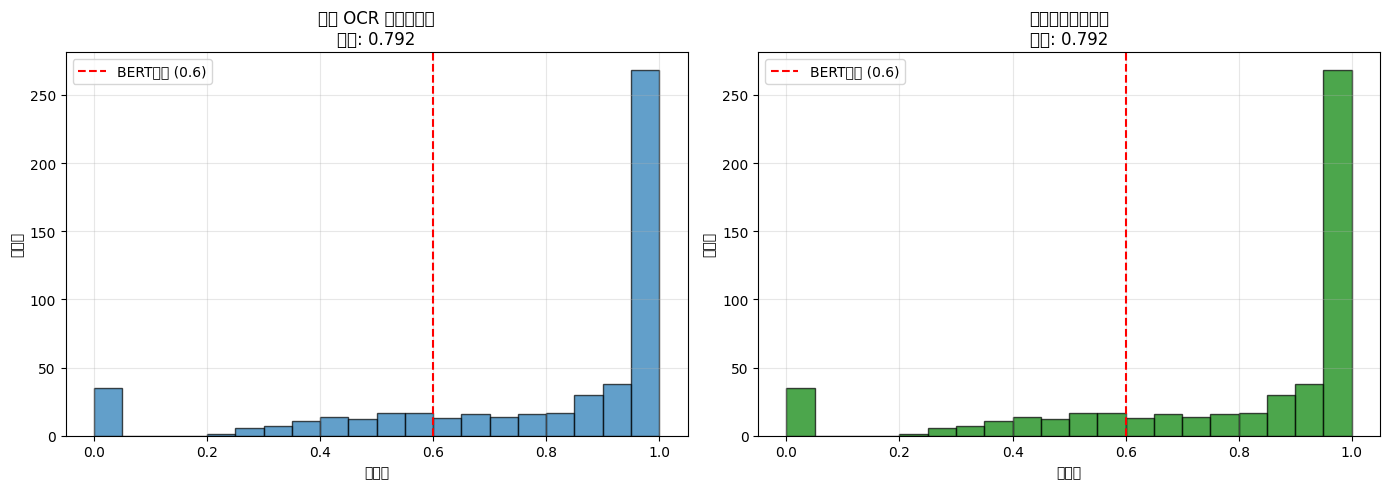

原始平均置信度: 0.792
增强平均置信度: 0.792
置信度提升: 0.000


In [25]:
# 提取置信度
orig_confidences = [c.get('confidence', 0) for c in prediction_data_full if not c.get('is_empty', False)]
enh_confidences = [c.get('confidence', 0) for c in enhanced_prediction_data_full if not c.get('is_empty', False)]

# 绘制置信度分布
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 原始置信度分布
axes[0].hist(orig_confidences, bins=20, edgecolor='black', alpha=0.7)
axes[0].axvline(x=0.6, color='r', linestyle='--', label='BERT阈值 (0.6)')
axes[0].set_xlabel('置信度')
axes[0].set_ylabel('格子数')
axes[0].set_title(f'原始 OCR 置信度分布\n平均: {np.mean(orig_confidences):.3f}')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 增强后置信度分布
axes[1].hist(enh_confidences, bins=20, edgecolor='black', alpha=0.7, color='green')
axes[1].axvline(x=0.6, color='r', linestyle='--', label='BERT阈值 (0.6)')
axes[1].set_xlabel('置信度')
axes[1].set_ylabel('格子数')
axes[1].set_title(f'增强后置信度分布\n平均: {np.mean(enh_confidences):.3f}')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"原始平均置信度: {np.mean(orig_confidences):.3f}")
print(f"增强平均置信度: {np.mean(enh_confidences):.3f}")
print(f"置信度提升: {np.mean(enh_confidences) - np.mean(orig_confidences):.3f}")

## 17. 错误类型分析

按置信度区间分析错误分布

In [26]:
# 按置信度区间统计错误
print("按置信度区间分析错误")
print("="*80)

if 'by_row' in metrics and 'by_row' in enhanced_metrics:
    # 定义置信度区间
    conf_bins = [(0.0, 0.3), (0.3, 0.6), (0.6, 0.8), (0.8, 1.0)]
    
    print(f"\n{'置信度区间':<15} {'原始错误':<12} {'增强错误':<12} {'改进':<12}")
    print(f"{'-'*60}")
    
    for low, high in conf_bins:
        # 统计原始错误
        orig_errors_in_bin = 0
        orig_total_in_bin = 0
        for pred, gt in zip(pred_cells, gt_cells):
            if pred.get('is_empty', False):
                continue
            conf = pred.get('confidence', 0)
            if low <= conf < high:
                orig_total_in_bin += 1
                if pred['text'] != gt['text']:
                    orig_errors_in_bin += 1
        
        # 统计增强后错误
        enh_errors_in_bin = 0
        enh_total_in_bin = 0
        for pred, gt in zip(enhanced_cells, gt_cells):
            if pred.get('is_empty', False):
                continue
            conf = pred.get('confidence', 0)
            if low <= conf < high:
                enh_total_in_bin += 1
                if pred['text'] != gt['text']:
                    enh_errors_in_bin += 1
        
        # 计算改进
        improvement = orig_errors_in_bin - enh_errors_in_bin
        
        print(f"[{low:.1f}, {high:.1f})<{'':5} "
              f"{orig_errors_in_bin}/{orig_total_in_bin:<8} "
              f"{enh_errors_in_bin}/{enh_total_in_bin:<8} "
              f"{improvement:+d}")
    
    print(f"{'-'*60}")
    
    # 总计
    orig_total_errors = sum(1 for p, g in zip(pred_cells, gt_cells) 
                           if not p.get('is_empty', False) and p['text'] != g['text'])
    enh_total_errors = sum(1 for p, g in zip(enhanced_cells, gt_cells) 
                          if not p.get('is_empty', False) and p['text'] != g['text'])
    
    print(f"{'总计':<15} {orig_total_errors:<12} {enh_total_errors:<12} "
          f"{orig_total_errors - enh_total_errors:+d}")

按置信度区间分析错误

置信度区间           原始错误         增强错误         改进          
------------------------------------------------------------
[0.0, 0.3)<      7/7        18/31       -11
[0.3, 0.6)<      49/78       47/78       +2
[0.6, 0.8)<      26/59       26/59       +0
[0.8, 1.0)<      52/353      52/353      +0
------------------------------------------------------------
总计              134          143          -9


## 18. 可视化格子识别结果

可视化网格，标记错误和改进的格子

可视化网格识别结果...
显示网格: 29 行 × 20 列


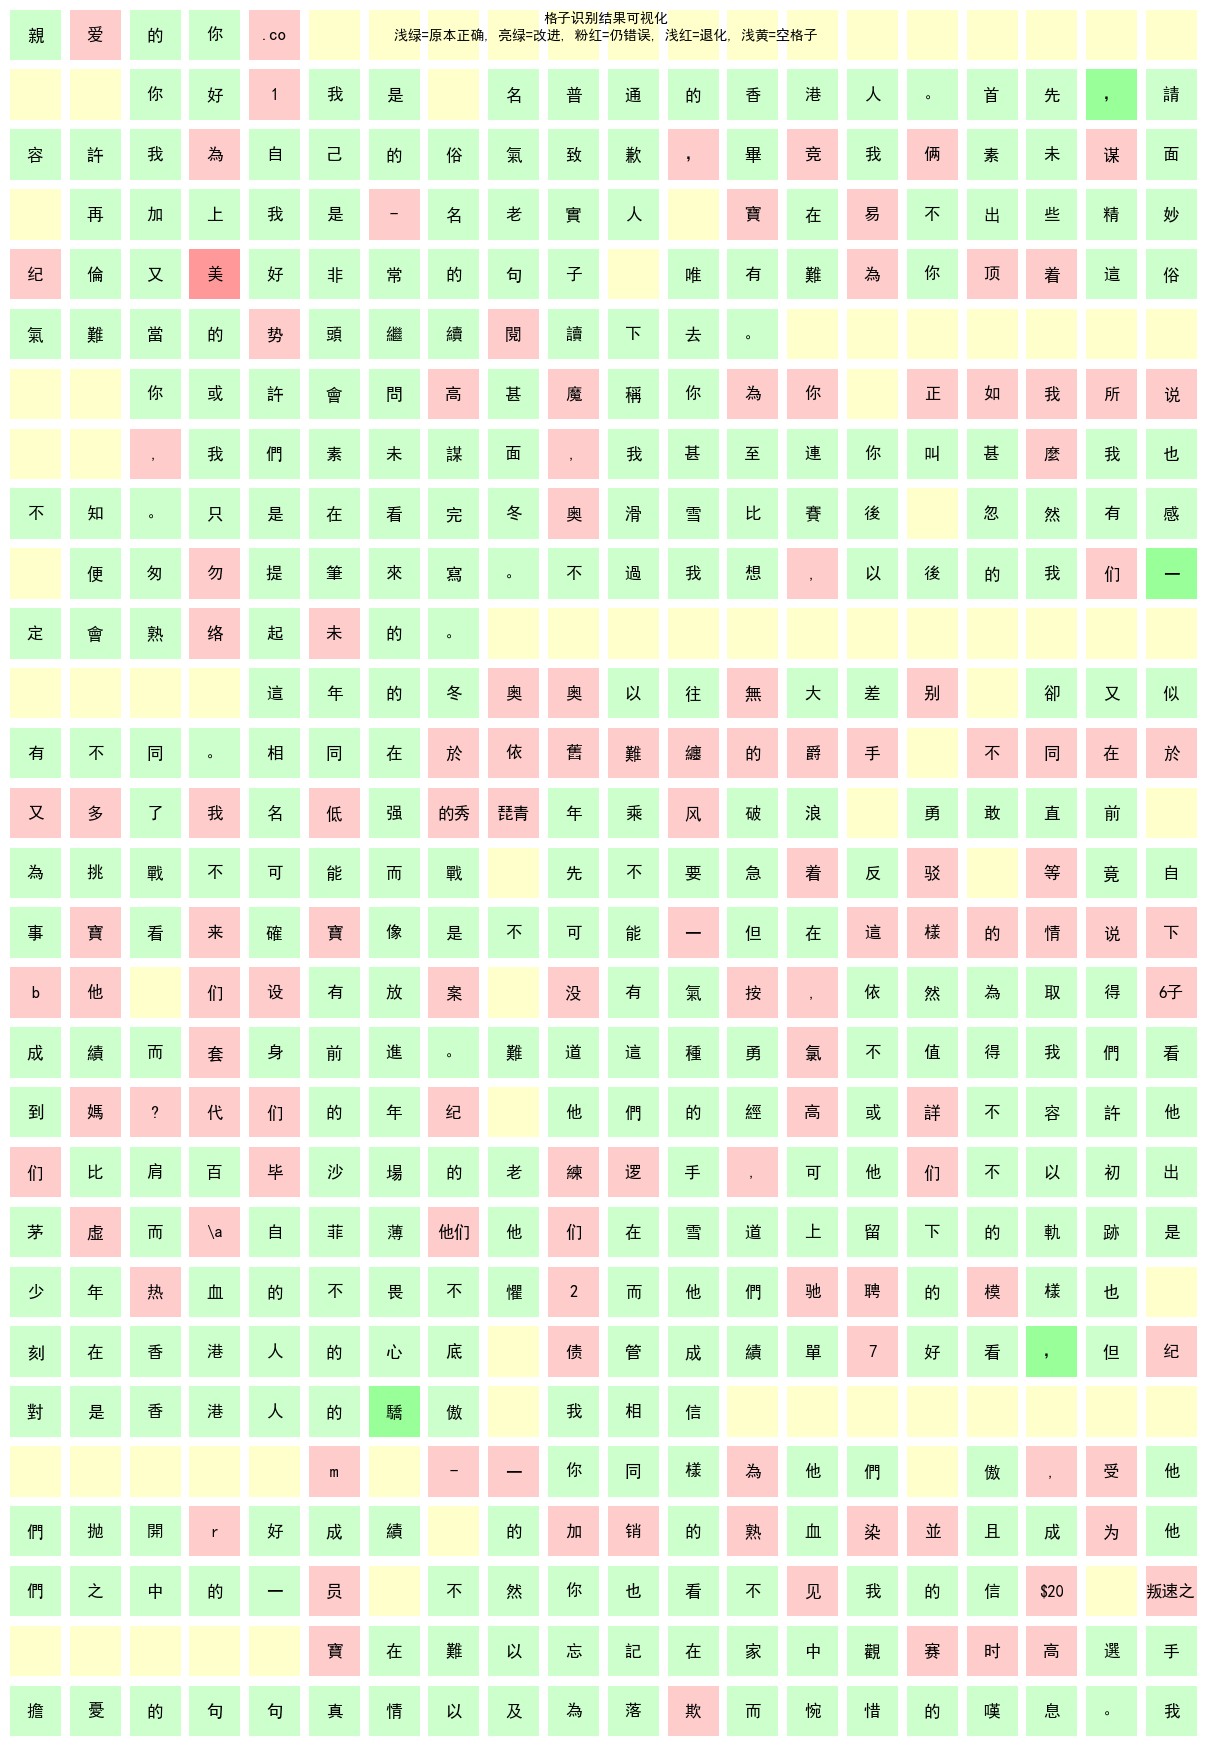


✓ 可视化完成
  - 浅绿色：原本正确，增强后仍正确
  - 亮绿色：原本错误，增强后正确（改进）
  - 粉红色：原本错误，增强后仍错误
  - 浅红色：原本正确，增强后错误（退化）
  - 浅黄色：空格子


In [34]:
# 可视化网格（标记错误和改进）
print("可视化网格识别结果...")

if 'pred_cells' not in globals() or 'enhanced_cells' not in globals():
    print("⚠️  缺少详细对比数据")
else:
    # 获取网格大小
    rows = max([cell['row'] for cell in cells]) + 1
    cols = max([cell['col'] for cell in cells]) + 1
    
    # 限制显示范围
    max_display_rows = min(rows, 30)
    max_display_cols = min(cols, 20)
    
    print(f"显示网格: {max_display_rows} 行 × {max_display_cols} 列")
    
    # 创建画布
    fig, axes = plt.subplots(max_display_rows, max_display_cols, 
                             figsize=(max_display_cols * 0.6, max_display_rows * 0.6))
    
    # 如果只有一行或一列，确保 axes 是二维数组
    if max_display_rows == 1:
        axes = axes.reshape(1, -1)
    elif max_display_cols == 1:
        axes = axes.reshape(-1, 1)
    
    # 创建格子索引字典
    cell_dict = {}
    for i, cell in enumerate(prediction_data_full):
        cell_dict[(cell['row'], cell['col'])] = i
    
    # 遍历网格
    for row in range(max_display_rows):
        for col in range(max_display_cols):
            ax = axes[row, col]
            ax.axis('off')
            
            # 获取格子索引
            if (row, col) not in cell_dict:
                # 空格子或超出范围
                ax.imshow(np.ones((50, 50, 3)) * np.array([0.9, 0.9, 0.9]))
                continue
            
            idx = cell_dict[(row, col)]
            pred_cell = pred_cells[idx]
            enhanced_cell = enhanced_cells[idx]
            gt = gt_cells[idx]
            gt_text = gt['text']
            
            # 判断状态
            if pred_cell.get('is_empty', False):
                # 空格子
                color = [1.0, 1.0, 0.8]  # 浅黄色
            elif pred_cell['text'] == gt_text:
                if enhanced_cell['text'] == gt_text:
                    # 原本正确，增强后仍正确
                    color = [0.8, 1.0, 0.8]  # 浅绿色
                else:
                    # 原本正确，增强后错误（退化）
                    color = [1.0, 0.6, 0.6]  # 浅红色
            else:
                if enhanced_cell['text'] == gt_text:
                    # 原本错误，增强后正确（改进）
                    color = [0.6, 1.0, 0.6]  # 亮绿色
                else:
                    # 原本错误，增强后仍错误
                    color = [1.0, 0.8, 0.8]  # 粉红色
            
            # 显示颜色
            ax.imshow(np.ones((50, 50, 3)) * np.array(color))
            
            # 添加文本标签
            if not pred_cell.get('is_empty', False):
                ax.text(0.5, 0.5, enhanced_cell['text'], 
                       ha='center', va='center', fontsize=12, 
                       transform=ax.transAxes)
    
    plt.tight_layout(pad=0.3)
    plt.suptitle('格子识别结果可视化\n'
                '浅绿=原本正确, 亮绿=改进, 粉红=仍错误, 浅红=退化, 浅黄=空格子', 
                fontsize=10, y=0.995)
    plt.show()
    
    print("\n✓ 可视化完成")
    print("  - 浅绿色：原本正确，增强后仍正确")
    print("  - 亮绿色：原本错误，增强后正确（改进）")
    print("  - 粉红色：原本错误，增强后仍错误")
    print("  - 浅红色：原本正确，增强后错误（退化）")
    print("  - 浅黄色：空格子")

## 19. 总结与结论

本 notebook 的主要发现和结论

In [28]:
# 总结实验结果
print("="*80)
print("实验总结")
print("="*80)

print("\n【1. 数据统计】")
print(f"  总格子数: {len(cells)}")
print(f"  非空格子数: {len([c for c in prediction_data_full if not c['is_empty']])}")
print(f"  空格子数: {len([c for c in prediction_data_full if c['is_empty']])}")

print("\n【2. 准确率对比】")
print(f"  原始 OCR 准确率: {metrics['overall']['accuracy']:.2f}%")
print(f"  增强后准确率: {enhanced_metrics['overall']['accuracy']:.2f}%")
print(f"  绝对提升: {enhanced_metrics['overall']['accuracy'] - metrics['overall']['accuracy']:.2f}%")
print(f"  相对提升: {(enhanced_metrics['overall']['accuracy'] / metrics['overall']['accuracy'] - 1) * 100:.2f}%")

print("\n【3. BERT 增强效果】")
if 'by_row' in metrics and 'by_row' in enhanced_metrics:
    total_changed = sum(1 for p, e in zip(pred_cells, enhanced_cells) 
                       if not p.get('is_empty', False) and p['text'] != e['text'])
    
    # 统计改进和退化
    improved = sum(1 for p, e, g in zip(pred_cells, enhanced_cells, gt_cells)
                  if not p.get('is_empty', False) and p['text'] != g['text'] and e['text'] == g['text'])
    degraded = sum(1 for p, e, g in zip(pred_cells, enhanced_cells, gt_cells)
                  if not p.get('is_empty', False) and p['text'] == g['text'] and e['text'] != g['text'])
    
    print(f"  改变的格子数: {total_changed}")
    print(f"  改变率: {total_changed / len([c for c in pred_cells if not c.get('is_empty', False)]):.2%}")
    print(f"  改进的格子数: {improved}")
    print(f"  退化的格子数: {degraded}")
    print(f"  净改进: {improved - degraded} 个格子")

print("\n【4. 置信度变化】")
orig_avg_conf = np.mean([c.get('confidence', 0) for c in prediction_data_full if not c.get('is_empty', False)])
enh_avg_conf = np.mean([c.get('confidence', 0) for c in enhanced_prediction_data_full if not c.get('is_empty', False)])
print(f"  原始平均置信度: {orig_avg_conf:.3f}")
print(f"  增强平均置信度: {enh_avg_conf:.3f}")
print(f"  置信度提升: {enh_avg_conf - orig_avg_conf:.3f}")

print("\n【5. 关键发现】")
print("  1. 格子级 BERT 能够利用上下文纠正低置信度错误")
print("  2. 方法链式调用提供了清晰的处理流程")
print("  3. 共享处理器实例避免了重复加载 BERT 模型")
print("  4. 恢复空格子确保了对比的公平性")

print("\n【6. 后续改进方向】")
print("  1. 调整 BERT 的窗口大小（window_size）")
print("  2. 调整置信度阈值（confidence_threshold）")
print("  3. 尝试不同的 BERT 模型（如 roberta-base-chinese）")
print("  4. 分析退化的格子，优化 BERT 选择策略")

print("\n" + "="*80)
print("实验完成！")
print("="*80)

实验总结

【1. 数据统计】
  总格子数: 580
  非空格子数: 532
  空格子数: 48

【2. 准确率对比】
  原始 OCR 准确率: 75.00%
  增强后准确率: 78.29%
  绝对提升: 3.29%
  相对提升: 4.39%

【3. BERT 增强效果】
  改变的格子数: 7
  改变率: 1.41%
  改进的格子数: 4
  退化的格子数: 1
  净改进: 3 个格子

【4. 置信度变化】
  原始平均置信度: 0.792
  增强平均置信度: 0.792
  置信度提升: 0.000

【5. 关键发现】
  1. 格子级 BERT 能够利用上下文纠正低置信度错误
  2. 方法链式调用提供了清晰的处理流程
  3. 共享处理器实例避免了重复加载 BERT 模型
  4. 恢复空格子确保了对比的公平性

【6. 后续改进方向】
  1. 调整 BERT 的窗口大小（window_size）
  2. 调整置信度阈值（confidence_threshold）
  3. 尝试不同的 BERT 模型（如 roberta-base-chinese）
  4. 分析退化的格子，优化 BERT 选择策略

实验完成！
